In [1]:
# -------------------------------------------------
# generate .txt files of time series data to
# feed into scepter climatology
# -------------------------------------------------

In [2]:
import os

import cftime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# ---
# set ensemble
LE_ens_tag = "1231-001"  # ensemble member start year and member id

# ---
# set time duration constraints
lterm_mean = True
# set start and end date
start_year = 1950  # set large bounds for easy way to get full data (e.g., 0-4000)
end_year = 2020
n_yr_repeatmean = 100  # only used if lterm_mean = True

# ---
datdir = (
    "/home/tykukla/aglime-swap-cdr/cesm2/data/postprocessed"  # location of cesm2le data
)
save_path = "/home/tykukla/aglime-swap-cdr/scepter/clim-inputs"  # location for climatology files

In [3]:
# --- information about vars


class Var:
    def __init__(self, varname, filename, dataset_loc, colname_var, colname_time):
        self.varname = varname
        self.filename = filename
        self.dataset_loc = dataset_loc
        self.colname_var = colname_var
        self.colname_time = colname_time

In [4]:
# --- function to write output file


def write_output(outdir, var, arrvar, arrtime):
    file_path = os.path.join(outdir, var.filename)
    # open the file in write mode
    with open(file_path, "w") as file:
        # write header
        h1 = "# " + var.colname_time
        h2 = var.colname_var
        file.write(f"{h1}\t{h2}\n")
        # write each pair of values from the arrays to the file
        for value1, value2 in zip(arrtime, arrvar):
            formatted_value1 = f"{value1:.7f}"
            formatted_value2 = f"{value2:.7f}"
            file.write(
                f"{formatted_value1}\t{formatted_value2}\n"
            )  # Separate values by tab and end line with newline character

In [5]:
# --- function to generate synthetic runoff and soil moisture data
def generate_synthetic_data(mean_runoff, mean_soil_moisture, 
                            peak_day_runoff, peak_day_soil_moisture, 
                            amplitude_runoff=1, amplitude_soil_moisture=1, 
                            years=1):
    """
    Generate synthetic monthly runoff and soil moisture data using sine waves.

    Parameters:
        mean_runoff (float): Mean annual runoff value.
        mean_soil_moisture (float): Mean annual soil moisture value.
        peak_day_runoff (int): Day of year when runoff peaks (1-365).
        peak_day_soil_moisture (int): Day of year when soil moisture peaks (1-365).
        amplitude_runoff (float): Amplitude of runoff sine wave. Default is 1.
        amplitude_soil_moisture (float): Amplitude of soil moisture sine wave. Default is 1.
        years (int): Number of years to generate data for. Default is 1.

    Returns:
        pd.DataFrame: A dataframe with columns for year, month, runoff, and soil_moisture.
    """
    days_per_year = 365

    # Generate timestamps for each month
    dates = pd.date_range(start="1/1/2000", periods=12 * years, freq="MS")
    
    # Calculate day of year for each month midpoint
    day_of_year = dates.day_of_year + (dates.days_in_month / 2 - 0.5)

    # Normalize day of year to radians
    radians_runoff = (2 * np.pi * (day_of_year - peak_day_runoff) / days_per_year)
    radians_soil_moisture = (2 * np.pi * (day_of_year - peak_day_soil_moisture) / days_per_year)

    # Calculate sine wave values
    runoff = mean_runoff + amplitude_runoff * np.sin(radians_runoff)
    soil_moisture = mean_soil_moisture + amplitude_soil_moisture * np.sin(radians_soil_moisture)
    
    # Create DataFrame
    df = pd.DataFrame({
        "year": dates.year,
        "month": dates.month,
        "runoff": runoff,
        "soil_moisture": soil_moisture
    })
    
    return df

# same as above, but can pass it a 1d array of times as the fraction through the year
def generate_synthetic_data_v2(mean_runoff, mean_soil_moisture, 
                               peak_day_runoff, peak_day_soil_moisture, 
                               amplitude_runoff=1, amplitude_soil_moisture=1, 
                               time_fraction=None):
    """
    Generate synthetic runoff and soil moisture data using sine waves, 
    supporting a 1D array of time as the fraction of the year.

    Parameters:
        mean_runoff (float): Mean annual runoff value.
        mean_soil_moisture (float): Mean annual soil moisture value.
        peak_day_runoff (int): Day of year when runoff peaks (1-365).
        peak_day_soil_moisture (int): Day of year when soil moisture peaks (1-365).
        amplitude_runoff (float): Amplitude of runoff sine wave. Default is 1.
        amplitude_soil_moisture (float): Amplitude of soil moisture sine wave. Default is 1.
        time_fraction (array-like): 1D array of time as fraction-of-year (e.g., 0.5 is halfway through year 0).
                                    If None, defaults to generating 12 months for a single year.

    Returns:
        pd.DataFrame: A dataframe with columns for time_fraction, runoff, and soil_moisture.
    """
    days_per_year = 365

    # If no time_fraction is provided, default to 12 evenly spaced months over one year
    if time_fraction is None:
        time_fraction = np.linspace(0, 1, 12, endpoint=False)

    # Convert time_fraction to day of the year
    day_of_year = (time_fraction % 1) * days_per_year

    # Normalize day of year to radians
    radians_runoff = (2 * np.pi * (day_of_year - peak_day_runoff) / days_per_year)
    radians_soil_moisture = (2 * np.pi * (day_of_year - peak_day_soil_moisture) / days_per_year)

    # Calculate sine wave values
    runoff = mean_runoff + amplitude_runoff * np.sin(radians_runoff)
    soil_moisture = mean_soil_moisture + amplitude_soil_moisture * np.sin(radians_soil_moisture)

    # Create DataFrame
    df = pd.DataFrame({
        "time_fraction": time_fraction,
        "runoff": runoff,
        "soil_moisture": soil_moisture
    })
    
    return df



In [6]:
# --- read in datasets
fn_atm = "cesm2le_" + LE_ens_tag + "_atmosvars.zarr"
fn_lnd = "cesm2le_" + LE_ens_tag + "_landvars.zarr"
spin_in_path = "/home/tykukla/aglime-swap-cdr/scepter/batch-inputs"
spin_inputs = "spinup-inputs-high-ph-coords.csv"
# read in
dsatm = xr.open_zarr(os.path.join(datdir, fn_atm))
dslnd = xr.open_zarr(os.path.join(datdir, fn_lnd))
df = pd.read_csv(os.path.join(spin_in_path, spin_inputs))

In [26]:
# --- UN-COMMENT TO GENERATE SYNTHETIC RUNOFF AND SOIL MOISTURE PROFILES

# set synthetic pars
# (must be the same length as len(df))
mean_runoff = [12, 12, 12, 12]
mean_soil_moisture = [165, 165, 165, 165]
peak_day_runoff = [300,15,200,100]
peak_day_soil_moisture = [300,15,200,100]
amplitude_runoff = [11,1,1,11]
amplitude_soil_moisture = [160, 10, 10, 160]

# print(df.head())


In [27]:
# --- extract and save time series
# set start and end dates
start_date = cftime.datetime(start_year, 1, 1, has_year_zero=True, calendar="noleap")
end_date = cftime.datetime(end_year, 12, 31, has_year_zero=True, calendar="noleap")
# ---

use_synthetic_hydroclim = True

# get subdirs
save_subdir = "cesm2le_monthly_ens-" + LE_ens_tag
# loop through sites
for idx in range(len(df)):
    # site name
    thissite = df.loc[idx, "site"]
    # get the nearest lat and lon
    slat = df.loc[idx, "lat"]
    slon = df.loc[idx, "lon"]

    # write input files
    with open("inputvar_details.txt") as file:
        # skip the first line
        next(file)
        # loop through each line in the file
        for line in file:
            # create var object
            thisvar = Var(*line.strip().split(","))
            # set the temporary dataset
            if thisvar.dataset_loc == "atm":
                tmpds = dsatm.copy()
            else:
                tmpds = dslnd.copy()
            # get timeslice
            tmp_slice = tmpds.sel(time=slice(start_date, end_date))
            # pull out data
            if lterm_mean:
                tmp_slice2 = tmp_slice.sel(lat=slat, lon=slon, method="nearest")
                tmp_1yr = (
                    tmp_slice2[thisvar.varname]
                    .groupby("time.month")
                    .mean(dim="time")
                    .values
                )
                tmp = np.concatenate((tmp_1yr,) * n_yr_repeatmean, axis=0)
                nsteps = len(tmp)
                yrmin, yrmax = float(0), float(n_yr_repeatmean)
            if not lterm_mean:
                # clim data
                tmp = (
                    tmp_slice[thisvar.varname]
                    .sel(lat=slat, lon=slon, method="nearest")
                    .values
                )
                # yrs
                nsteps = len(tmpds["time"])
                yrmin, yrmax = float(0), float(nsteps / 12)
            # set yr array and save
            yrs = np.linspace(yrmin, yrmax, nsteps)
            # update arr if synthetic
            if use_synthetic_hydroclim and thisvar.colname_var in ['moisture(mm/m)', 'runoff(mm/month)']:
                # get climate ts
                dfclim_tmp = generate_synthetic_data_v2(mean_runoff[idx], mean_soil_moisture[idx], 
                                                    peak_day_runoff[idx], peak_day_soil_moisture[idx], amplitude_runoff[idx], 
                                                    amplitude_soil_moisture[idx], time_fraction=yrs)
                if thisvar.colname_var == "moisture(mm/m)":
                    tmp = np.array(dfclim_tmp['soil_moisture'])
                elif thisvar.colname_var == 'runoff(mm/month)':
                    tmp = np.array(dfclim_tmp['runoff'])
            # name the output directory
            if lterm_mean:
                yr_string = (
                    str(start_year)
                    + "-"
                    + str(end_year)
                    + "mean_x"
                    + str(n_yr_repeatmean)
                    + "yr"
                    + ["_synthHydro" if use_synthetic_hydroclim else ""][0]
                )
                savehere = os.path.join(save_path, save_subdir, yr_string, thissite)
            else:
                yr_string = str(start_year) + "-" + str(end_year)
                savehere = os.path.join(save_path, save_subdir, yr_string, thissite)
            # write the output file
            if not os.path.exists(savehere):
                os.makedirs(savehere)
            write_output(savehere, thisvar, tmp, yrs)

In [28]:
savehere

'/home/tykukla/aglime-swap-cdr/scepter/clim-inputs/cesm2le_monthly_ens-1231-001/1950-2020mean_x100yr_synthHydro/west4'

In [49]:
# ---------------------------------------------------------------------------------------- #
#
# ---------------------------------------------------------------------------------------- #

In [8]:
# --- read in .txt files
# get file names
f1, f2, f3 = "q_temp.in", "T_temp.in", "Wet_temp.in"

# Read the tab-delimited .txt file into a DataFrame
df1 = pd.read_csv(os.path.join(savehere, f1), delimiter="\t")
df2 = pd.read_csv(os.path.join(savehere, f2), delimiter="\t")
df3 = pd.read_csv(os.path.join(savehere, f3), delimiter="\t")
# check df1
print(df1)

      # time(yr)  runoff(mm/month)
0       0.000000         11.896720
1       0.083403         14.912403
2       0.166806         17.146438
3       0.250209         17.999241
4       0.333611         17.241931
...          ...               ...
1195   99.666389          6.861661
1196   99.749792          6.001029
1197   99.833194          6.750438
1198   99.916597          8.908755
1199  100.000000         11.896720

[1200 rows x 2 columns]


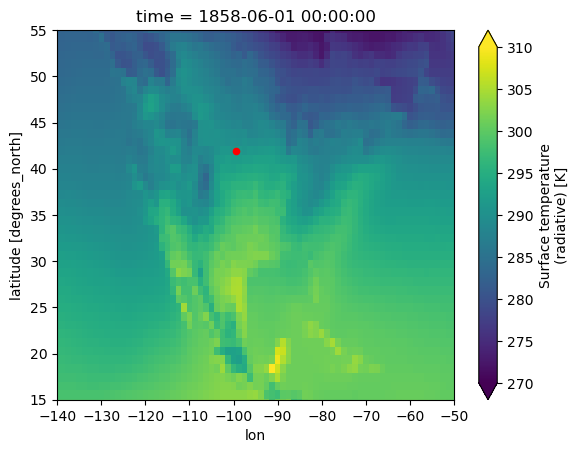

In [9]:
dsatm["TS"].isel(time=100).plot(xlim=[-140, -50], ylim=[15, 55], vmin=270, vmax=310)
plt.scatter(slon, slat, s=20, c="red")

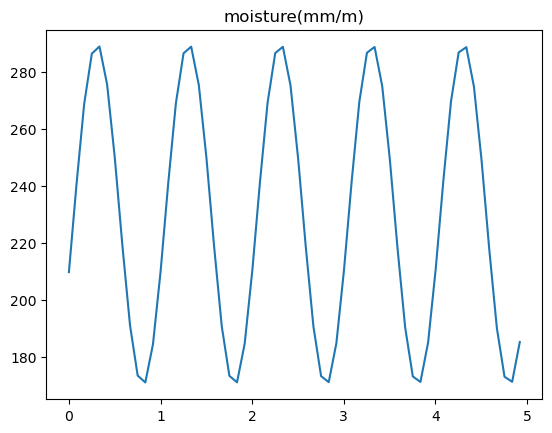

In [15]:
# --- quick sanity check plots
plotfirstXyears = 5

thisdf = df3.copy()

dfx1 = thisdf[thisdf.iloc[:, 0] < plotfirstXyears]
plt.plot(dfx1.iloc[:, 0], dfx1.iloc[:, 1])
plt.title(dfx1.columns[1]);

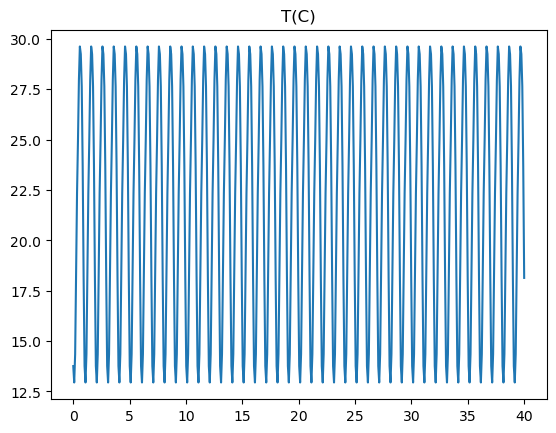

In [80]:
dfx2 = df2[df2.iloc[:, 0] < plotfirstXyears]
plt.plot(dfx2.iloc[:, 0], dfx2.iloc[:, 1])
plt.title(dfx2.columns[1]);

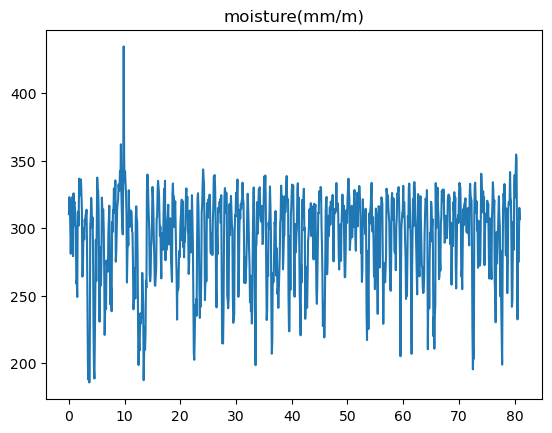

In [70]:
dfx3 = df3[df3.iloc[:, 0] < plotfirstXyears]
plt.plot(dfx3.iloc[:, 0], dfx3.iloc[:, 1])
plt.title(dfx3.columns[1]);

In [24]:
mean_runoff = [12, 12, 12, 12]
mean_soil_moisture = [165, 165, 165, 165]
peak_day_runoff = [300,15,200,100]
peak_day_soil_moisture = [300,15,200,100]
amplitude_runoff = [11,1,1,11]
amplitude_soil_moisture = [160, 10, 10, 160]

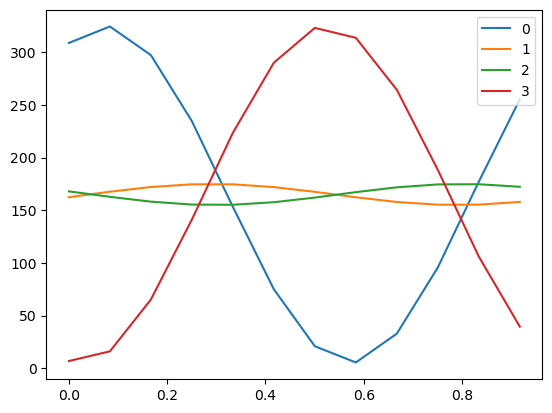

In [25]:
for idx in range(len(mean_runoff)):
    max_yr = 1
    pvar = "soil_moisture"

    dfclim_tmp = generate_synthetic_data_v2(mean_runoff[idx], mean_soil_moisture[idx], 
                                                        peak_day_runoff[idx], peak_day_soil_moisture[idx], amplitude_runoff[idx], 
                                                        amplitude_soil_moisture[idx], time_fraction=yrs)

    dfc = dfclim_tmp[dfclim_tmp['time_fraction'] < max_yr]
    plt.plot(dfc['time_fraction'], dfc[pvar], label=idx)
    plt.legend()

In [ ]:
# ---